In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from typing import List

In [16]:
transform=transforms.Compose([
    transforms.ToTensor(),
    ])
train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
test_dataset = datasets.MNIST('../data', train=False,
                   transform=transform)

In [128]:
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 30
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [147]:
class VAE(nn.Module):
    def __init__(self, in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None) -> None:
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.hidden_dims = [16, 32, 64, 128] if hidden_dims is None else hidden_dims
        hidden_dims = self.hidden_dims[::]
            
        # building encoder
        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                             kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            in_channels = h_dim
            
        self.encoder = nn.Sequential(*modules)
        
        # probability coefs
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)
    
        # building decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=2,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels = 3,
                                      kernel_size = 3, padding = 0),
                            nn.Tanh())
        
    def encode(self, input: torch.Tensor) -> List[torch.Tensor]:
        """
        Encodes the input by passing through encoder and returns latent codes.
        :param imput: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        
        # spliting the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        logvar = self.fc_var(result)
        
        return [mu, logvar]

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, self.hidden_dims[-1], 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result
        
    def forward(self, input: torch.Tensor):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]
    
    def loss_function(self, recons: torch.Tensor,
                      input: torch.Tensor,
                      mu: torch.Tensor,
                      log_var: torch.Tensor) -> dict:
        """
        Computes the VAE loss function.
        """
        rec_loss = F.mse_loss(recons, input)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        
        kld_weight = 1
        loss = rec_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':rec_loss, 'KLD':-kld_loss}
    
    def sample(self,
               num_samples:int,
               current_device: int) -> torch.Tensor:
        z = torch.randn(num_samples, self.latent_dim)
        
        samples = self.decode(z.to(current_device))
        
        return samples        

In [134]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    cum_rec_loss = 0
    cum_kl_loss = 0
    cum_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        results = model(data)
        train_loss = model.loss_function(*results)
#         print(epoch, {key: val.item() for key, val in train_loss.items()})
        cum_loss += train_loss["loss"].item()
        cum_rec_loss += train_loss["Reconstruction_Loss"].item()
        cum_kl_loss += train_loss["KLD"].item()
        train_loss['loss'].backward()
        optimizer.step()
    print(f"train - epoch = {epoch}, loss = {cum_loss / len(train_loader)}, rec_loss = {cum_rec_loss / len(train_loader)}, kl_loss = {cum_kl_loss / len(train_loader)}")


def test(model, device, test_loader):
    model.eval()
    cum_rec_loss = 0
    cum_kl_loss = 0
    cum_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            results = model(data)
            test_loss = model.loss_function(*results)
            cum_loss += test_loss["loss"].item()
            cum_rec_loss += test_loss["Reconstruction_Loss"].item()
            cum_kl_loss += test_loss["KLD"].item()
    print(f"validation - loss = {cum_loss / len(test_loader)}, rec_loss = {cum_rec_loss / len(test_loader)}, kl_loss = {cum_kl_loss / len(test_loader)}")

In [135]:
model = VAE(1, 30).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [148]:
for epoch in range(EPOCHS):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    
    torch.save(model, "./model.pth")

<ipython-input-130-ba8548b85338>:121: UserWarning: Using a target size (torch.Size([128, 1, 28, 28])) that is different to the input size (torch.Size([128, 3, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rec_loss = F.mse_loss(recons, input)


KeyboardInterrupt: 

In [8]:
model = torch.load("model.pth")
model.eval()

VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear

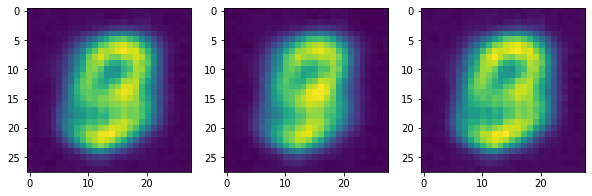

In [13]:
k = 3
data = model.sample(k, device)
fig, axes = plt.subplots(1, k, figsize=(10, 40))
for i in range(k):            
    axes[i].imshow(data[i,:,:,:].permute(1, 2, 0).cpu().detach().squeeze(0).numpy())
            

In [10]:
s.shape

torch.Size([3, 1, 28, 28])

In [11]:
import matplotlib.pyplot as plt

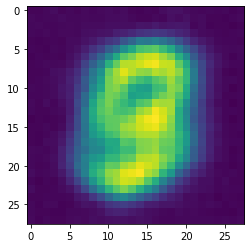

In [12]:
plt.imshow(s[2,:,:,:].permute(1, 2, 0).cpu().detach().squeeze(0).numpy())